# Implementing a support vector machine (SVM) to classify images of cats and dogs from the Kaggle dataset.

# Importing Required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import random
from PIL import Image
import plotly.graph_objects as go

for dirname, _, filenames in os.walk(r'C:\Users\siddartha\Downloads\dogs-vs-cats'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


C:\Users\siddartha\Downloads\dogs-vs-cats\sampleSubmission.csv
C:\Users\siddartha\Downloads\dogs-vs-cats\test1.zip
C:\Users\siddartha\Downloads\dogs-vs-cats\train.zip


# Extracting the datasets

In [2]:
import zipfile
import os

# Define paths
train_zip_path = r'C:\Users\siddartha\Downloads\dogs-vs-cats\train.zip'
test_zip_path = r'C:\Users\siddartha\Downloads\dogs-vs-cats\test1.zip'
train_extract_path = r'C:\kaggle\working\train'
test_extract_path = r'C:\kaggle\working\test'

# Extract train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)
    print(f'Extracted train.zip to {train_extract_path}')

# Extract test.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)
    print(f'Extracted test1.zip to {test_extract_path}')


Extracted train.zip to C:\kaggle\working\train
Extracted test1.zip to C:\kaggle\working\test


# Setting up paths

In [3]:
train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

# Function to load and preprocess the images

In [4]:
def load_images(folder, img_size=(64, 64), sample_count=20, label_filter=None):
    images = []
    labels = []
    filenames = os.listdir(folder)
    
    if label_filter is not None:
        filenames = [fname for fname in filenames if label_filter in fname]
    
    random.shuffle(filenames)
    for img in filenames[:sample_count]:
        try:
            img_path = os.path.join(folder, img)
            img_pil = Image.open(img_path)
            img_pil = img_pil.resize(img_size)
            img_np = np.array(img_pil) / 255.0  # Normalize pixel values
            images.append(img_np)
            labels.append(0 if 'cat' in img else 1)
        except Exception as e:
            print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

# Visualize images with labels

In [5]:
def visualize_images(images, labels, sample_count=20):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(sample_count):
        axes[i].imshow(images[i])
        axes[i].set_title('Cat' if labels[i] == 0 else 'Dog')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and visualize cat images

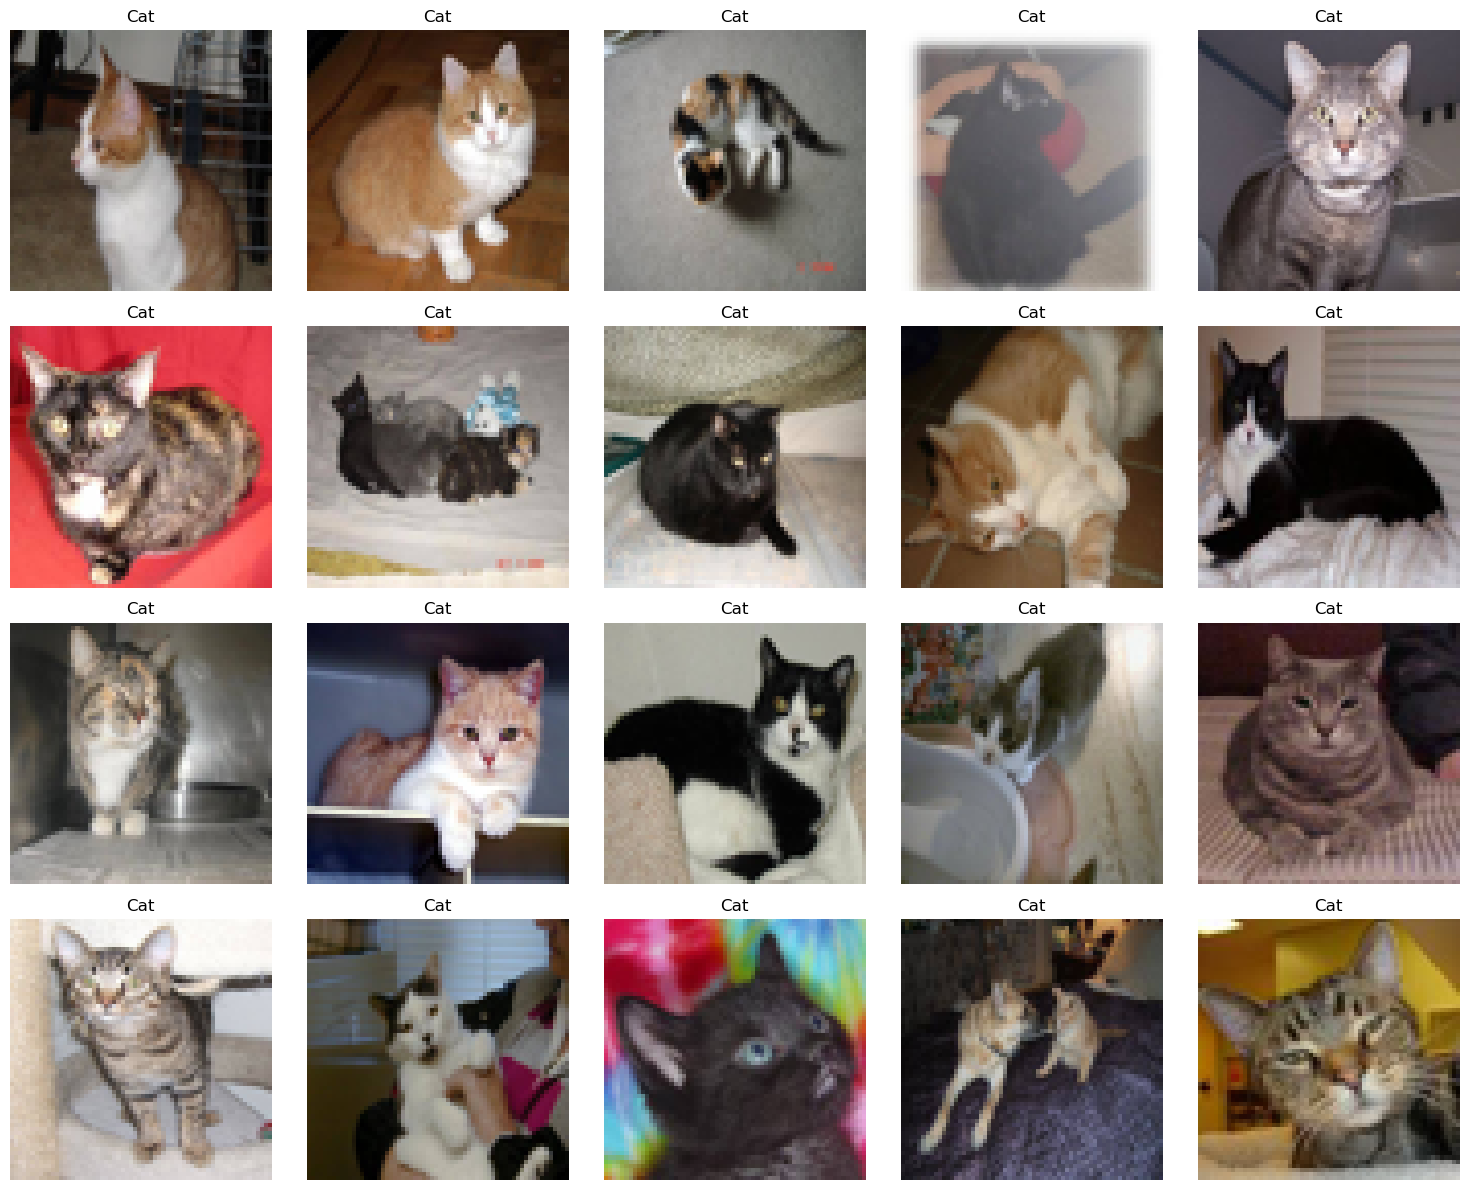

In [6]:
cat_images, cat_labels = load_images(train_dir, sample_count=20, label_filter='cat')
visualize_images(cat_images, cat_labels, sample_count=20)


# Load and visualize dog images 

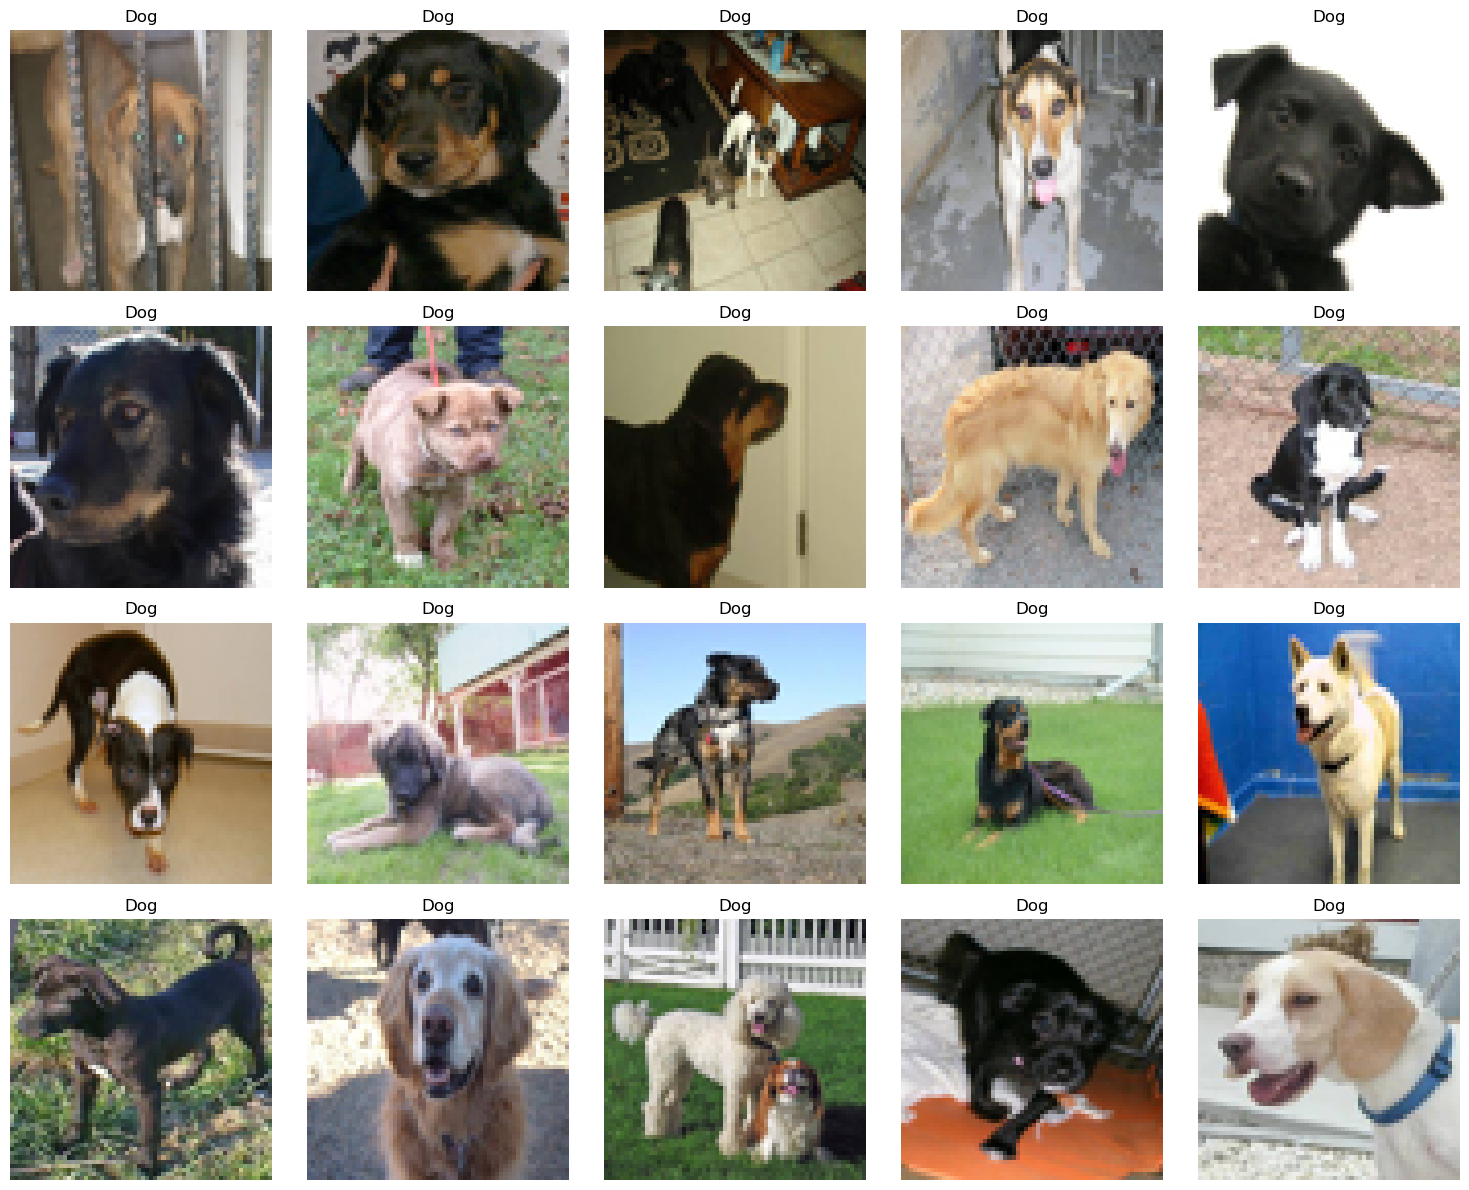

In [7]:
dog_images, dog_labels = load_images(train_dir, sample_count=20, label_filter='dog')
visualize_images(dog_images, dog_labels, sample_count=20)

# Load and visualize both cat and dog images

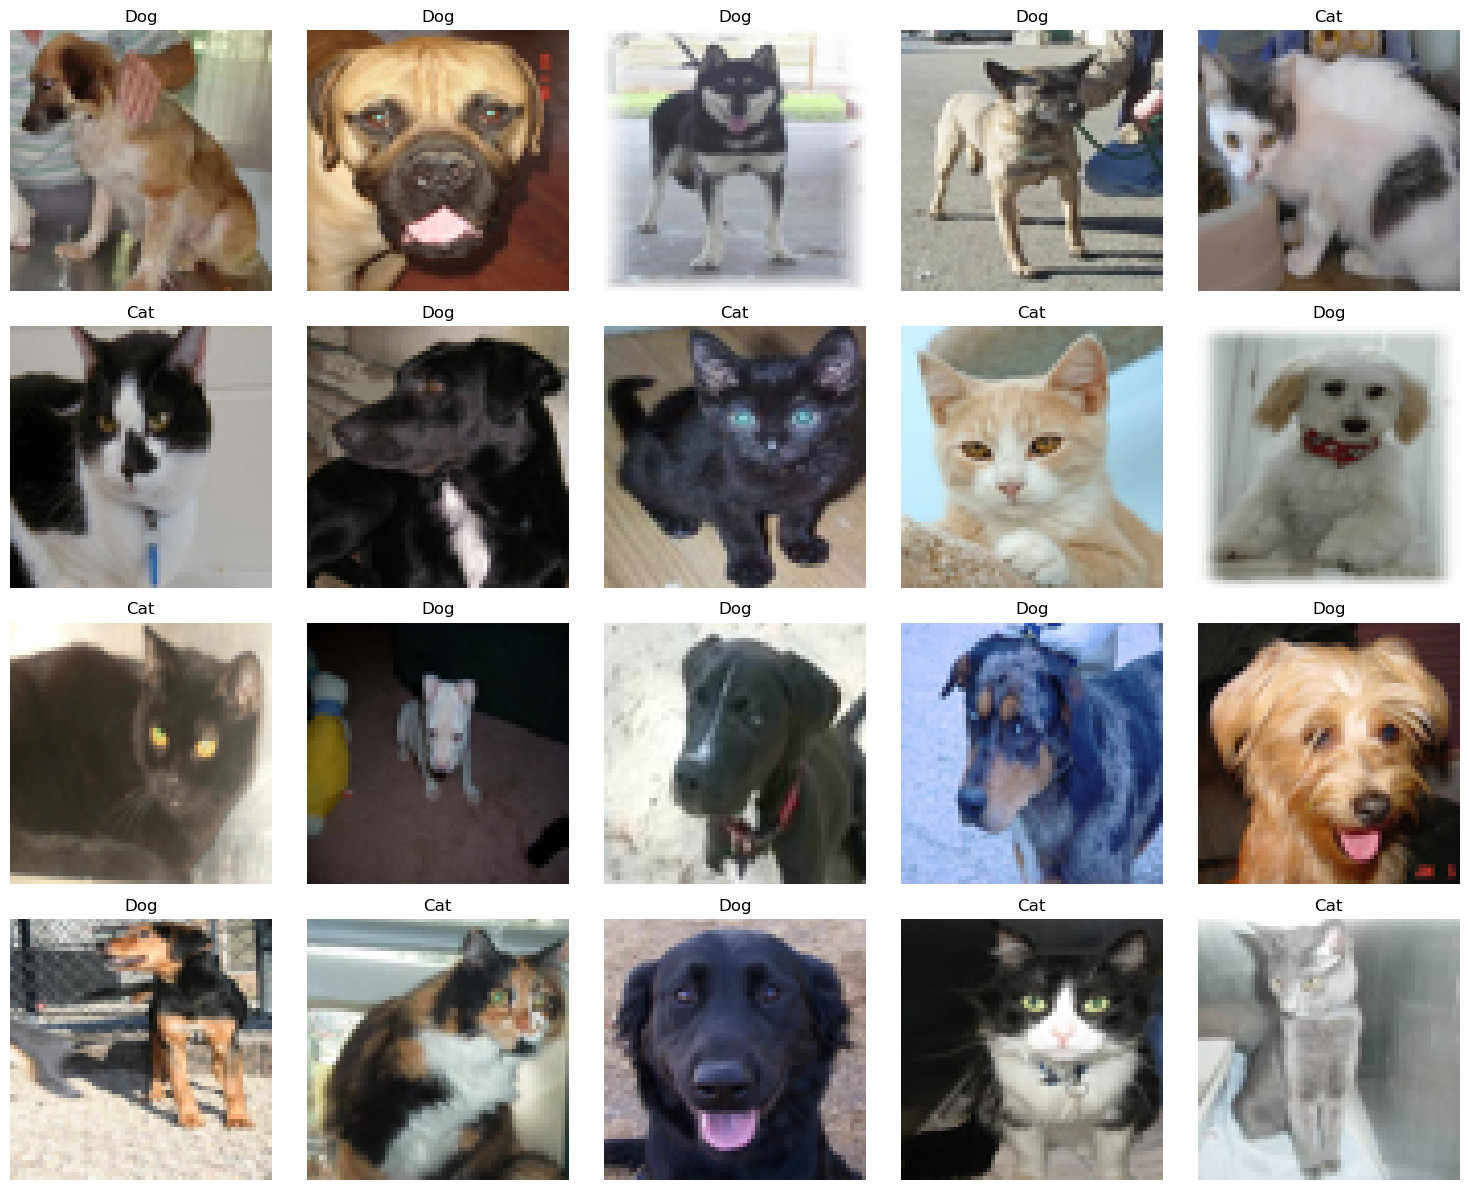

In [8]:
all_images, all_labels = load_images(train_dir, sample_count=20)
visualize_images(all_images, all_labels, sample_count=20)

# Loading and preprocessing the training data

In [9]:
images, labels = load_images(train_dir, sample_count=10000) 
images = images / 255.0

# Display the shape of the images array

In [10]:
print("Shape of images array:", images.shape)

Shape of images array: (10000, 64, 64, 3)


# Display the first 2 images

In [11]:
print(images[:2]) 
print(labels[:2])

[[[[1.53787005e-03 1.24567474e-03 9.84236832e-04]
   [1.78392926e-03 1.49173395e-03 1.23029604e-03]
   [1.49173395e-03 1.19953864e-03 9.38100730e-04]
   ...
   [1.96847366e-03 1.67627835e-03 1.41484045e-03]
   [1.95309496e-03 1.63014225e-03 1.36870434e-03]
   [1.83006536e-03 1.47635525e-03 1.23029604e-03]]

  [[1.53787005e-03 1.24567474e-03 9.84236832e-04]
   [1.78392926e-03 1.49173395e-03 1.23029604e-03]
   [1.49173395e-03 1.19953864e-03 9.38100730e-04]
   ...
   [1.78392926e-03 1.50711265e-03 1.24567474e-03]
   [1.78392926e-03 1.46097655e-03 1.21491734e-03]
   [1.70703576e-03 1.35332564e-03 1.10726644e-03]]

  [[1.50711265e-03 1.21491734e-03 9.53479431e-04]
   [1.76855056e-03 1.47635525e-03 1.21491734e-03]
   [1.50711265e-03 1.21491734e-03 9.53479431e-04]
   ...
   [1.73779316e-03 1.46097655e-03 1.19953864e-03]
   [1.73779316e-03 1.41484045e-03 1.16878124e-03]
   [1.66089965e-03 1.30718954e-03 1.06113033e-03]]

  ...

  [[1.03037293e-03 2.46059208e-04 2.30680507e-04]
   [1.03037293e-

# Flattening the images for the SVM input

In [12]:
n_samples, img_height, img_width, img_channels = images.shape
images_flat = images.reshape(n_samples, -1)

# Standardizing the features

In [13]:
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Applying t-SNE

In [14]:
perplexity = min(30, n_samples - 1)
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
images_tsne = tsne.fit_transform(images_flat_scaled)

# Splitting the dataset into training and test sets

In [15]:
X_train, X_val, y_train, y_val = train_test_split(images_flat_scaled, labels, test_size=0.2, random_state=42)

In [16]:
X_train

array([[-0.9723397 , -0.91293167, -0.66444861, ..., -1.41020217,
        -1.35052673, -1.04772649],
       [-0.74215382, -0.43610761, -0.74936706, ...,  1.36666735,
         1.50116548,  1.50212104],
       [-0.74215382, -0.8406856 , -1.49947998, ...,  1.01217337,
         1.30501734,  0.98922068],
       ...,
       [-1.69167059, -1.63539235, -1.48532691, ..., -0.90800236,
        -0.92805381, -1.13565227],
       [-1.04427279, -1.28861122, -1.15980621, ..., -0.25809673,
        -0.67155239, -0.73998627],
       [-0.25300881,  0.50309128, -0.39554021, ...,  0.00777376,
         0.56568973, -0.98910931]])

In [17]:

X_val

array([[ 0.04911016,  0.11296251,  0.39703194, ..., -0.36149081,
        -0.4301393 , -0.31501168],
       [ 0.66773472,  0.79207555,  0.90654261, ..., -0.70121421,
        -0.58102248, -0.37362887],
       [-1.31761853, -1.1585683 , -1.20226543, ..., -0.39103197,
        -0.33960938, -0.19777731],
       ...,
       [ 1.9481437 ,  2.03470793,  2.1095539 , ...,  1.85409658,
         1.98399168,  2.04433   ],
       [-0.65583411, -0.1037757 ,  0.01489894, ...,  0.21456191,
         0.53551309, -0.13916013],
       [-0.19546234, -0.29161548, -0.11247873, ...,  1.02694396,
         1.01833929,  0.9012949 ]])

In [18]:
y_val

array([0, 1, 0, ..., 1, 1, 0])

# Checking class distribution

In [19]:
unique, counts = np.unique(labels, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

Class distribution: {0: 4978, 1: 5022}


In [20]:
def plot_tsne_data(tsne_data, labels, title):
    df_tsne = pd.DataFrame()
    df_tsne['X'] = tsne_data[:, 0]
    df_tsne['Y'] = tsne_data[:, 1]
    df_tsne['Label'] = labels
    df_tsne['Label'] = df_tsne['Label'].map({0: 'Cat', 1: 'Dog'})
    
    fig = px.scatter(df_tsne, x='X', y='Y', color='Label', title=title)
    fig.show()

plot_tsne_data(images_tsne, labels, 't-SNE visualization of Cats vs Dogs')

# Training the SVM model

In [21]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

# Making predictions on the validation set

In [22]:

y_val_pred = svm.predict(X_val)

In [23]:
y_val_pred

array([1, 1, 1, ..., 1, 1, 0])

# Evaluating the model

In [24]:
val_accuracy = accuracy_score(y_val, y_val_pred)
val_class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Accuracy

In [25]:
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.5495


# Classification Report

In [26]:
print('Validation Classification Report:')
print(val_class_report)

Validation Classification Report:
              precision    recall  f1-score   support

         Cat       0.54      0.58      0.56       994
         Dog       0.56      0.52      0.54      1006

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



# Confusion Matrix

Validation Confusion Matrix:
[[576 418]
 [483 523]]


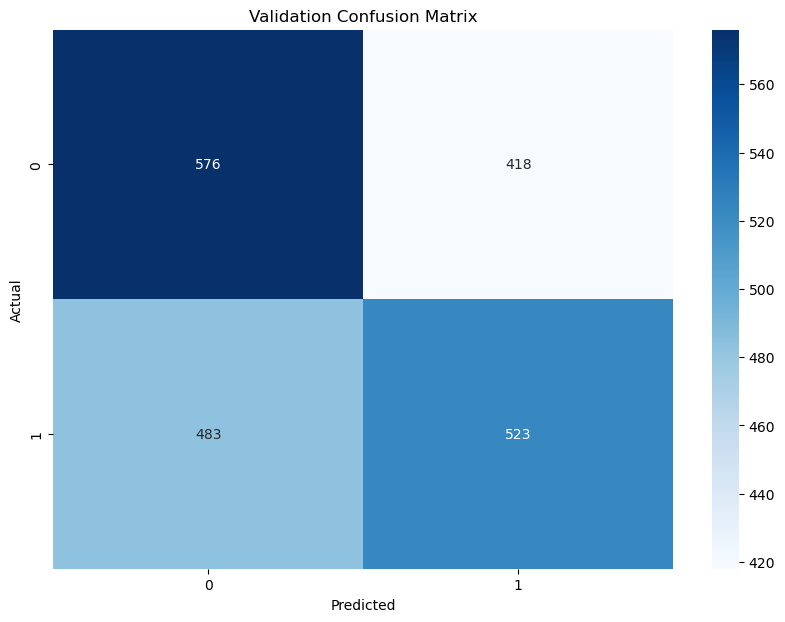

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
print('Validation Confusion Matrix:')
print(val_conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

# Saving the SVM model and scaler

In [28]:
import pickle
with open('/kaggle/working/svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Loading and preprocessing the test data

In [29]:
test_images, test_labels = load_images(test_dir)  
test_images = test_images / 255.0

# Flattening the test images for the SVM input

In [30]:
n_test_samples, test_img_height, test_img_width, test_img_channels = test_images.shape
test_images_flat = test_images.reshape(n_test_samples, -1)
test_images_flat_scaled = scaler.transform(test_images_flat)

# Standardizing the test features

In [31]:
test_images_flat_scaled = scaler.transform(test_images_flat)

# Applying t-SNE for visualization on test data

In [32]:
# Determine a new perplexity value for the test data
test_perplexity = min(30, n_test_samples - 1)

# Create a new t-SNE instance for the test data
test_tsne = TSNE(n_components=2, perplexity=test_perplexity, random_state=42)
test_images_tsne = test_tsne.fit_transform(test_images_flat_scaled)

# Making predictions on the test set

In [33]:
y_test_pred = svm.predict(test_images_flat_scaled)
y_test_pred

array([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

# Creating a DataFrame for Plotly

In [34]:
df_test_tsne = pd.DataFrame()
df_test_tsne['X'] = test_images_tsne[:, 0]
df_test_tsne['Y'] = test_images_tsne[:, 1]
df_test_tsne['Predicted Label'] = y_test_pred
df_test_tsne['Predicted Label'] = df_test_tsne['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

# Plotting with Plotly

In [35]:
fig = px.scatter(df_test_tsne, x='X', y='Y', color='Predicted Label', title='t-SNE visualization of Test Data Predictions')
fig.show()

# Visualizing some of the test results with Plotly

In [36]:
def plot_test_samples(images, tsne_data, predictions, sample_count=10):
    sample_indices = np.random.choice(range(len(images)), sample_count, replace=False)
    sample_images = images[sample_indices]
    tsne_samples = tsne_data[sample_indices]
    pred_samples = predictions[sample_indices]

    fig = px.scatter(tsne_samples, x=tsne_samples[:, 0], y=tsne_samples[:, 1], color=pred_samples.astype(str),
                     title="Test Data Predictions (t-SNE Space)")
    fig.show()

plot_test_samples(test_images, test_images_tsne, y_test_pred)

# Saving the test predictions to a CSV file

In [37]:
test_predictions = pd.DataFrame({'Id': np.arange(1, n_test_samples + 1), 'Label': y_test_pred})
test_predictions['Label'] = test_predictions['Label'].map({0: 'Cat', 1: 'Dog'})
test_predictions.to_csv('/kaggle/working/test_predictions.csv', index=False)

In [38]:
def plot_samples(tsne_data, y_true, y_pred, sample_count=10):
    sample_indices = np.random.choice(range(len(tsne_data)), sample_count, replace=False)
    tsne_samples = tsne_data[sample_indices]
    y_true_samples = y_true[sample_indices]
    y_pred_samples = y_pred[sample_indices]

    df_tsne_samples = pd.DataFrame()
    df_tsne_samples['X'] = tsne_samples[:, 0]
    df_tsne_samples['Y'] = tsne_samples[:, 1]
    df_tsne_samples['True Label'] = y_true_samples
    df_tsne_samples['Predicted Label'] = y_pred_samples
    df_tsne_samples['True Label'] = df_tsne_samples['True Label'].map({0: 'Cat', 1: 'Dog'})
    df_tsne_samples['Predicted Label'] = df_tsne_samples['Predicted Label'].map({0: 'Cat', 1: 'Dog'})

    fig = px.scatter(df_tsne_samples, x='X', y='Y', color='True Label', symbol='Predicted Label', title="True vs Predicted Labels (t-SNE Space)")
    fig.show()

# Apply t-SNE to the validation data
val_tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
val_images_tsne = val_tsne.fit_transform(X_val)

# Plot true vs predicted labels for the validation set
plot_samples(val_images_tsne, y_val, y_val_pred)

In [39]:
test_predictions.to_csv('test_predictions.csv', index=False)
